In [1]:
import numpy as np
from sklearn.model_selection import train_test_split
import torch.nn as nn
from torch.optim import Adam
from torch.utils.data.sampler import WeightedRandomSampler

from triagerx.dataset.processor import DatasetProcessor
from triagerx.model.roberta_cnn import RobertaCNNClassifier
from triagerx.trainer.model_trainer import ModelTrainer
from triagerx.trainer.train_config import TrainConfig

# Load Data

In [2]:
dataset_path = "/home/mdafifal.mamun/notebooks/triagerX/notebook/data/deeptriage/classifier_data_5.csv"

In [3]:
import pandas as pd

In [14]:
import random

def clean_data(df):
    df['text'] = df['text'].str.replace('http[s]?://(?:[a-zA-Z]|[0-9]|[$-_@.&+]|[!*\(\),]|(?:%[0-9a-fA-F][0-9a-fA-F]))+', ' ')
    df["text"] = df['text'].str.replace(" +", " ", regex=True)

    return df
    
def prepare_dataframe(df: pd.DataFrame, minimum_contribution = 300) -> pd.DataFrame:
    # developers = df["owner"].value_counts()
    # filtered_developers = developers.index[developers >= minimum_contribution]
    # df = df[df["owner"].isin(filtered_developers)]

    df["text"] = df.apply(lambda x: "Title: " + str(x["issue_title"]) + "\nDescription: " + str(x["description"]), axis=1)
    
    min_length = 15
    df = df[df["text"].str.len().gt(min_length)]

    # owners = list(set(df["owner"]))
    # keep_random = random.sample(owners, 100)
    # df = df[df["owner"].isin(keep_random)]

    df["owner_id"] = pd.factorize(df["owner"])[0]

    return df

In [15]:
df = pd.read_csv(dataset_path)
df = prepare_dataframe(df)
df = clean_data(df)

<Axes: xlabel='owner'>

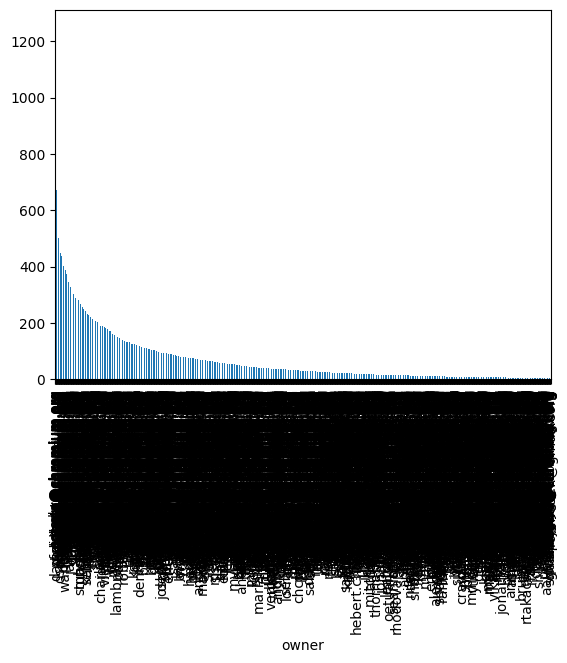

In [16]:
df["owner"].value_counts().plot(kind="bar")

In [17]:
np.random.seed(42)
train_df, test_df = train_test_split(df, test_size=0.15, stratify=df["owner_id"])
train_df, valid_df = train_test_split(train_df, test_size=0.2, stratify=train_df["owner_id"])

In [18]:
assert len(train_df.owner_id.unique()) == len(train_df.owner_id.unique()) == len(valid_df.owner_id.unique())

In [19]:
len(df.owner_id.unique())

1691

# Training

In [16]:
model = RobertaCNNClassifier(
    model_name="roberta-large",
    output_size=len(train_df.owner_id.unique()),
    embed_size=1024
)

Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.weight', 'roberta.pooler.dense.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [17]:
import torch

In [18]:
class_counts = np.bincount(train_df["owner_id"])
num_samples = sum(class_counts)
labels = train_df["owner_id"].to_list() #corresponding labels of samples

class_weights = [num_samples/class_counts[i] for i in range(len(class_counts))]
weights = [class_weights[labels[i]] for i in range(int(num_samples))]
sampler = WeightedRandomSampler(torch.DoubleTensor(weights), int(num_samples))

In [20]:
learning_rate = 1e-6
epochs = 50
batch_size = 15

# Create sampler
# counts = np.bincount(train_df["owner_id"])
# labels_weights = 1. / counts
# weights = labels_weights[train_df["owner_id"]]
# sampler = WeightedRandomSampler(weights, len(weights))

sampler_name = sampler.__class__.__name__ if sampler else "None"
model_name = model.__class__.__name__

output_file = f"dt_{model_name}_{20}_stratify_comp-labels_{sampler_name}"
output_path = f"/home/mdafifal.mamun/notebooks/triagerX/output/{output_file}.pt"

wandb_config = {
        "project": "triagerx",
        "name": f"run_{output_file}",
        "config": {
        "learning_rate": learning_rate,
        "architecture": "Roberta-CNN",
        "dataset": "deeptriage",
        "epochs": epochs,
    }
}

criterion = nn.CrossEntropyLoss()
optimizer = Adam(model.parameters(), lr=learning_rate)

train_config = TrainConfig(
    optimizer=optimizer,
    criterion=criterion,
    train_dataset=train_df,
    validation_dataset=valid_df,
    learning_rate=learning_rate,
    batch_size=batch_size,
    epochs=epochs,
    output_file=output_path,
    sampler=sampler,
    wandb=wandb_config
)

trainer = ModelTrainer(train_config)
trainer.train(model=model)

2024-01-17 22:25:44.935 | DEBUG    | triagerx.dataset.triage_dataset:__init__:17 - Generating torch dataset...
2024-01-17 22:25:44.938 | DEBUG    | triagerx.dataset.triage_dataset:__init__:20 - Tokenizing texts...
2024-01-17 22:26:00.728 | DEBUG    | triagerx.dataset.triage_dataset:__init__:17 - Generating torch dataset...
2024-01-17 22:26:00.730 | DEBUG    | triagerx.dataset.triage_dataset:__init__:20 - Tokenizing texts...
2024-01-17 22:26:04.667 | DEBUG    | triagerx.trainer.model_trainer:train:33 - Initializing wandb...
wandb: Currently logged in as: afifaniks. Use `wandb login --relogin` to force relogin


2024-01-17 22:26:11.775 | DEBUG    | triagerx.trainer.model_trainer:train:48 - Selected compute device: cuda
  0%|          | 0/677 [00:00<?, ?it/s]/home/mdafifal.mamun/miniconda3/envs/trx/lib/python3.10/site-packages/torch/nn/modules/conv.py:456: UserWarning: Applied workaround for CuDNN issue, install nvrtc.so (Triggered internally at /opt/conda/conda-bld/pytorch_1702400366987/work/aten/src/ATen/native/cudnn/Conv_v8.cpp:80.)
  return F.conv2d(input, weight, bias, self.stride,
  8%|▊         | 55/677 [01:03<11:54,  1.15s/it]


KeyboardInterrupt: 

# Evaluation

In [7]:
import torch
from triagerx.evaluation.evaluator import Evaluator

In [9]:
model = RobertaCNNClassifier(
    model_name="roberta-large",
    output_size=len(train_df.owner_id.unique()),
    embed_size=1024
)
model.load_state_dict(torch.load("/home/mdafifal.mamun/notebooks/triagerX/output/dt_RobertaCNNClassifier_5_stratify_comp-labels_WeightedRandomSampler.pt"))

evaluator = Evaluator()

NameError: name 'train_df' is not defined

In [15]:
from torch.utils.data import DataLoader
from triagerx.dataset.triage_dataset import TriageDataset

dataset = TriageDataset(test_df, model.tokenizer())

2024-01-17 21:16:27.106 | DEBUG    | triagerx.dataset.triage_dataset:__init__:17 - Generating torch dataset...
2024-01-17 21:16:27.110 | DEBUG    | triagerx.dataset.triage_dataset:__init__:20 - Tokenizing texts...


In [16]:
loader = DataLoader(dataset, 15)

In [17]:
device = "cuda"
all_preds = []
all_labels = []

model = model.cuda()

with torch.no_grad():

    for val_input, val_label in loader:
        val_label = val_label.to(device)
        mask = val_input["attention_mask"].to(device)
        input_id = val_input["input_ids"].squeeze(1).to(device)

        output = model(input_id, mask)
        output = nn.Softmax(dim=1)(output)
        conf, classes = output.topk(3, dim=1)

        batch_loss = criterion(output, val_label.long())
        # total_loss_val += batch_loss.item()

        acc = (output.argmax(dim=1) == val_label).sum().item()
        
        all_preds.append(classes.cpu().numpy())
        all_labels.append(val_label.cpu().numpy())
        
        # total_acc_val += acc

In [18]:
# all_preds[0]

array([[ 1,  4,  8],
       [ 4,  8,  1],
       [ 1,  9,  8],
       [14,  0,  2],
       [ 8,  4,  1],
       [ 3, 11, 10],
       [ 0,  2, 10],
       [ 3, 10, 11],
       [ 0, 14,  2],
       [ 2,  0,  8],
       [ 0,  2, 14],
       [14,  0, 10],
       [10,  3,  2],
       [15,  6,  1],
       [ 3, 10, 11]])

In [38]:
# all_preds = np.concatenate(all_preds)
# all_labels = np.concatenate(all_labels)

In [41]:
# set(all_labels)

{0,
 1,
 2,
 3,
 4,
 5,
 6,
 7,
 8,
 9,
 10,
 11,
 12,
 13,
 14,
 15,
 16,
 17,
 18,
 19,
 20,
 21,
 22,
 23,
 24,
 25,
 26,
 27,
 28,
 29,
 30,
 31,
 32,
 33,
 34,
 35,
 36,
 37,
 38,
 39,
 40,
 41,
 42,
 43,
 44,
 45,
 46,
 47,
 48,
 49}

In [40]:
# all_preds[0]

array([ 1, 31,  7])

In [26]:
# sum(all_preds == all_labels)

445

In [20]:
# set(all_labels) - set(all_preds)

{0, 3, 13, 18, 20, 22, 23, 25, 28, 32, 35, 38, 41, 45, 46, 47, 48}

In [19]:
# Top 3 Predictions
evaluator.calculate_top_k_accuray(model, k=3, X_test=test_df, y_test=test_df["owner_id"].to_numpy())

2024-01-17 21:16:56.736 | DEBUG    | triagerx.evaluation.evaluator:calculate_top_k_accuray:22 - Calculating predications...
2024-01-17 21:17:15.441 | DEBUG    | triagerx.evaluation.evaluator:calculate_top_k_accuray:52 - Calculating top 3 score...
2024-01-17 21:17:15.450 | INFO     | triagerx.evaluation.evaluator:calculate_top_k_accuray:55 - Top 3 score: 0.8793103448275862


0.8793103448275862

In [20]:
# Top 5 Predictions
evaluator.calculate_top_k_accuray(model, k=5, X_test=test_df, y_test=test_df["owner_id"].to_numpy())

2024-01-17 21:17:15.659 | DEBUG    | triagerx.evaluation.evaluator:calculate_top_k_accuray:22 - Calculating predications...
2024-01-17 21:17:34.386 | DEBUG    | triagerx.evaluation.evaluator:calculate_top_k_accuray:52 - Calculating top 5 score...
2024-01-17 21:17:34.401 | INFO     | triagerx.evaluation.evaluator:calculate_top_k_accuray:55 - Top 5 score: 0.9396551724137931


0.9396551724137931